<a href="https://colab.research.google.com/github/lucaskmiyazaki/kalman-filter/blob/master/robotica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Filtro de Kalman Extendido<h2>

<h5>Lucas Kyoshi Miyazaki   </h5>
<h5>Ricardo Ken Wang Tsuzuki</h5>

-----------------------------------------------------------------------
O programa deve ser rodado no Google Colab, clique em Runtime > Run All e selecione (na célula abaixo) o arquivo "valores.csv" salvo na pasta local

In [ ]:
# Selecione da sua pasta local o arquivo anexado no pdf "valores.csv"
from google.colab import files
uploaded = files.upload()

Saving valores.csv to valores (1).csv


In [ ]:
import io
import pandas as pd
df2 = pd.read_csv(io.BytesIO(uploaded["valores.csv"]))
data = df2.reset_index().values
data

array([[0, 0, '0', 0.4715929926606419, -0.5002873334578906,
        2.1021802590401943],
       [1, 0, '0', 0.518979607302205, -0.9687424937561804,
        1.8150450743105344],
       [2, 0, '0', 0.5200976929390357, -0.9739999586834288,
        1.9497486571516744],
       ...,
       [3447, 0, '0', 0.6315486696597662, -0.698985104660939,
        2.611418432414486],
       [3448, 0, '0', 0.6885843184094996, -1.6793990566824426,
        2.4563859053512442],
       [3449, 0, '0', 0.7091029955162655, -0.9896890332402648,
        0.9246051970178684]], dtype=object)

<h1>O Problema do Triciclo</h1>
Um triciclo no espaço 2d se move em torno de uma antena posicionada na origem do referencial. Seja $X_t$ variaveis de estado, $U_t$ valores dos atuadores, $Z_t$ valores dos sensores:

$X_t = [x, y, \theta, f_x, f_y]$, 
$U_t = [v, \phi]$, 
$Z_t = [\rho, b_f, b_e]$
 
*   $x$ e $y$: posição do triciclo em relação à antena
*   $\theta$: ângulo entre eixo longitudinal do triciclo e x, algumas vezes chamaremos ele de z
*   $f_x$ e $f_y$: componentes do vetor fluxo magnético
*   $v$: velocidade longitudinal imposta pelas rodas
*   $\phi$: ângulo de basculamento da roda dianteira
*   $\rho$: distância do robô até a antena
*   $b_f$ e $b_e$: projeção do campo magnético na longitudinal e transversal
*   $l$: o comprimento do eixo longitudinal
*   $b$: a distância entre as rodas traseiras
*   $h$: altura da antena
*   $\Delta t$: O intervalo de tempo entre cada estado. O valor de $\Delta t$ é 0,25s.


![alt text](https://drive.google.com/uc?id=1LfhJQBDLCpxI8V4wgWHF3WwxFkKUvfj4)

Foi utilizada a biblioteca do Sympy para manipulação simbólica para se encontrar as matrizes do filtro de Kalman de uma forma fácil. Infelizmente, não é possível rodar os programas dos exercícios 4 e 6 com as matrizes do Sympy, pois o programa fica muito lento. Portanto, estes dois exercícios (que utilizam o numpy) encontram-se no final deste jupiter notebook.

In [ ]:
import numpy as np
from sympy import *
x = symbols("x")
y = symbols("y")
z = symbols("theta")
fx = symbols("fx")
fy = symbols("fy")
v = symbols("v")
p = symbols("phi")
r = symbols("rho")
be = symbols("be")
bf = symbols("bf")
dt = symbols("dt")
l = 0.3
h = 0.5
sx = symbols("sx")
sy = symbols("sy")
sz = symbols("sz")
sr = symbols("sr")
se = symbols("se")
sf = symbols("sf")

<h1>Perturbações</h1>
Robôs estão sempre sujeitos a perturbações que podem enviesar as variáveis de estado do nosso triciclo.

$R_{triciclo} = \begin{bmatrix}
s_l^2 & 0 & 0 & 0 & 0\\
0 & s_t^2 & 0 & 0 & 0\\
0 & 0 & s_{\theta}^2 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0
\end{bmatrix}$ 

$l_{local} = T \cdot l_{global}$

$T = \begin{bmatrix}
cos(\theta) & sin(\theta) & 0& 0 & 0\\
-sin(\theta) & cos(\theta) & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 1
\end{bmatrix}$

$R_{global} = T^{-1}R(T^{-1})^{T} = T^TRT$

$Q_{t} = \begin{bmatrix}
s_{\rho}^2 & 0 & 0\\
0 & s_{f}^2 & 0 \\
0 & 0 & s_{e}^2
\end{bmatrix}$ 

*   $s_x$ e $s_y$: perturbação da posição na longitudinal e transversal
*   $s_{\theta}$: perturbação na posição angular 
*   $s_{\rho}$: perturbação de medição da distância até antena
*   $s_{f}$ e $s_{e}$: perturbação de medição do campo magnético


$s_x^2 = (\frac{v\Delta t}{6})^2$, $s_y^2 = (\frac{v\Delta t}{12})^2$, $s_{\theta}^2 = (\frac{v\Delta t}{8l})^2$

$s_r = \frac{h^2+x^2+y^2}{20^2}$, $s_f = 1/4$, $s_e = 1/4$

In [ ]:
T = Matrix([[cos(z), sin(z), 0, 0, 0], [-sin(z), cos(z), 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]])
R = Matrix([[sx, 0, 0, 0, 0], [0, sy, 0, 0, 0], [0, 0, sz, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]])
R = T.T*R*T
Q = Matrix([[sr, 0, 0], [0, sf, 0], [0, 0, se]])

<h1>Q1 - Lei de Recorrencia</h1>

$X_t = F(X_{t-1}, U_t) + \epsilon_t$

$F(X_{t-1}, U_t) = \begin{bmatrix}
x+v \cdot \Delta t \cdot cos(\theta) cos(\phi)\\
y+v \cdot \Delta t \cdot sin(\theta) cos(\phi)\\
\theta+ \frac{v}{l} \cdot \Delta t \cdot tan(\phi) \\
f_x \\
f_y
\end{bmatrix}$

valor de R esta no codigo abaixo

$R = \begin{bmatrix}
s_xcos(\theta)^2 + s_ysin(\theta)^2 & s_xsin(\theta)cos(\theta) - s_ysin(\theta)cos(\theta)& 0& 0& 0\\ 
s_xsin(\theta)cos(\theta) - s_ysin(\theta)cos(\theta) &  s_xsin(\theta)^2 + s_ycos(\theta)^2 & 0& 0& 0\\
 0& 0& sz& 0& 0\\ 
 0& 0& 0& 0& 0\\ 
 0& 0& 0& 0& 0
\end{bmatrix}$

In [ ]:
F = Matrix([x + v*dt*cos(z)*cos(p), y + v*dt*sin(z)*cos(p), z + v*dt*tan(p)/l, fx, fy])
print(R)

Matrix([[sx*cos(theta)**2 + sy*sin(theta)**2, sx*sin(theta)*cos(theta) - sy*sin(theta)*cos(theta), 0, 0, 0], [sx*sin(theta)*cos(theta) - sy*sin(theta)*cos(theta), sx*sin(theta)**2 + sy*cos(theta)**2, 0, 0, 0], [0, 0, sz, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]])


<h1>Q2 - Lei de Medição</h1>

$Z_t = G(X_{t}) + \delta_t$

$G(X_{t}) = \begin{bmatrix}
\sqrt{x^2+y^2+h^2}\\
f_xcos(\theta)+f_ysin(\theta) \\
-f_xsin(\theta)+f_ycos(\theta)
\end{bmatrix}$

In [ ]:
G = Matrix([(x**2 + y**2 + h**2)**(1/2), fx*cos(z) + fy*sin(z), -fx*sin(z) + fy*cos(z)])

<h1>Q3 - Antes de Incorporar Medições</h1>



$A_t = \nabla_X F(X, U) = \begin{bmatrix}
1 & 0 & -v \Delta t sin(\theta) cos(\phi) & 0 & 0\\
0 & 1 & v \Delta t cos(\theta) cos(\phi)& 0 & 0\\
0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 1
\end{bmatrix}$ 

$\bar\Sigma_t = A_t \Sigma A_t^T + R_t$

$\bar\mu_t = F(X_{t-1}, U_t)$


In [ ]:
A = Matrix([diff(F, x).T, diff(F, y).T, diff(F, z).T, diff(F, fx).T, diff(F, fy).T]).T
A

Matrix([
[1, 0, -dt*v*sin(theta)*cos(phi), 0, 0],
[0, 1,  dt*v*cos(phi)*cos(theta), 0, 0],
[0, 0,                         1, 0, 0],
[0, 0,                         0, 1, 0],
[0, 0,                         0, 0, 1]])

<h1>Q5 - Incorporando as Medições</h1>

$C_t = \nabla_X G(X) = \begin{bmatrix}
\frac{x}{\sqrt{x^2+y^2+h^2}} & \frac{y}{\sqrt{x^2+y^2+h^2}} & 0 & 0 & 0\\
0 & 0 & -f_xsin(\theta) + f_ycos(\theta) & cos(\theta) & sin(\theta)\\
0 & 0 & -f_xcos(\theta) - f_ysin(\theta) & -sin(\theta) & cos(\theta)
\end{bmatrix}$ 

$K_t = \bar\Sigma_t C_t^T(C_t\bar\Sigma_t C_t^T+Q_t)^{-1}$

$\mu = \bar\mu + K_t(Z_t-G(\mu_t))$

$\Sigma_t = (I-K_tC_t)\bar\Sigma_t$

In [ ]:
C = Matrix([diff(G, x).T, diff(G, y).T, diff(G, z).T, diff(G, fx).T, diff(G, fy).T]).T
C

Matrix([
[1.0*x*(x**2 + y**2 + 0.25)**(-0.5), 1.0*y*(x**2 + y**2 + 0.25)**(-0.5),                              0,           0,          0],
[                                 0,                                  0, -fx*sin(theta) + fy*cos(theta),  cos(theta), sin(theta)],
[                                 0,                                  0, -fx*cos(theta) - fy*sin(theta), -sin(theta), cos(theta)]])

<h1>Q4 - Algoritmo Sem Medições</h1>


In [ ]:
import numpy as np
from sympy.parsing.sympy_parser import parse_expr
# All values must be float numbers
S0 = np.array([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 10.0, 0], [0, 0, 0, 0, 10.0]])
M0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
dt = 0.25 #1000/len(data)
l = 0.3
statesx = []
statesy = []

# O algoritmo retorna as medias das variaveis de estado 
def kalman1(M0, S0):
  for i in range(1000):
    # Definicao das var
    U0 = np.array([data[i][1], data[i][2]])
    v = float(U0[0])
    try:
      #phi = np.deg2rad(float(U0[1]))
      phi = float(U0[1])
    except:
      new_str = ''
      for c in U0[1]:
        if c == 'P':
          new_str = new_str + '3.1415'
        elif c!= 'i':
          new_str = new_str + c
      phi = float(parse_expr(new_str))
    x = float(M0[0])
    y = float(M0[1])
    theta = float(M0[2])
    fx = float(M0[3]) 
    fy = float(M0[4])
    sx = (dt*v/6)**2
    sy = (dt*v/12)**2
    sz = (dt*v/(8*l))**2 
    # Filtro sem as medicoes
    M = np.array([[dt*v*np.cos(theta)*np.cos(phi)+x], [dt*v*np.sin(theta)*np.cos(phi)+y], [dt*v*np.tan(phi)/l + theta], [fx], [fy]])
    A = np.array([[1, 0, -dt*v*np.sin(theta)*np.cos(phi), 0, 0], [0, 1, dt*v*np.cos(theta)*np.cos(phi), 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]])
    R = np.array([[sx*np.cos(theta)**2 + sy*np.sin(theta)**2, sx*np.sin(theta)*np.cos(theta) - sy*np.sin(theta)*np.cos(theta), 0, 0, 0], [sx*np.sin(theta)*np.cos(theta) - sy*np.sin(theta)*np.cos(theta), sx*np.sin(theta)**2 + sy*np.cos(theta)**2, 0, 0, 0], [0, 0, sz, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]])
    S = A.T*S0*A + R
    M0 = M
    S0 = S
    statesx.append(M[0])
    statesy.append(M[1])
  print("Valores de covariancia finais")
  #print(S)
  print("cov(x) = "+str(S[0][0]))
  print("cov(y) = "+str(S[1][1]))
  print("cov(x,y) = "+str(S[1][0]))
  
  return M0

final = kalman1(M0, S0)

Valores de covariancia finais
cov(x) = 0.6391853054440519
cov(y) = 0.6650681667781696
cov(x,y) = -0.00020332998429735839


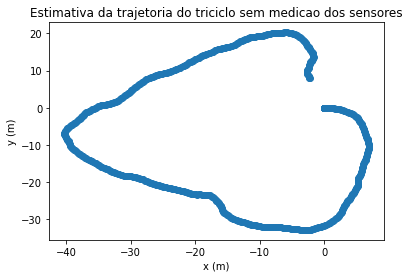

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(statesx, statesy)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Estimativa da trajetoria do triciclo sem medicao dos sensores")
plt.show()


<h1>Q6 - Algoritmo com Medição</h1>

In [ ]:
print(C)

Matrix([[1.0*x*(x**2 + y**2 + 0.25)**(-0.5), 1.0*y*(x**2 + y**2 + 0.25)**(-0.5), 0, 0, 0], [0, 0, -fx*sin(theta) + fy*cos(theta), cos(theta), sin(theta)], [0, 0, -fx*cos(theta) - fy*sin(theta), -sin(theta), cos(theta)]])


In [ ]:
# All values must be float numbers
import numpy as np
from sympy.parsing.sympy_parser import parse_expr
S0 = np.array([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 10.0, 0], [0, 0, 0, 0, 10.0]])
M0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
dt = 0.25 #1000/len(data)
l = 0.3
h = 0.5
statesx = []
statesy = []

# O algoritmo retorna as medias das variaveis de estado 
def kalman2(M0, S0):
  for i in range(len(data)):
    # definicao das var
    U0 = np.array([data[i][1], data[i][2]])
    Z0 = np.array([[float(data[i][3])], [float(data[i][4])], [float(data[i][5])]])
    U0 = np.array([data[i][1], data[i][2]])
    v = float(U0[0])
    try:
      #phi = np.deg2rad(float(U0[1]))
      phi = float(U0[1])
    except:
      new_str = ''
      for c in U0[1]:
        if c == 'P':
          new_str = new_str + '3.1415'
        elif c!= 'i':
          new_str = new_str + c
      phi = float(parse_expr(new_str))
    x = float(M0[0])
    y = float(M0[1])
    theta = float(M0[2])
    fx = float(M0[3]) 
    fy = float(M0[4])
    sx = (dt*v/6)**2
    sy = (dt*v/12)**2
    sz = (dt*v/(8*l))**2 
    sr = (h**2+x**2+y**2)/20**2
    sf = 1/4
    se = 1/4

    # Filtro sem medicao
    M1 = np.array([[dt*v*np.cos(theta)*np.cos(phi)+x], [dt*v*np.sin(theta)*np.cos(phi)+y], [dt*v*np.tan(phi)/l + theta], [fx], [fy]])
    A = np.array([[1, 0, -dt*v*np.sin(theta)*np.cos(phi), 0, 0], [0, 1, dt*v*np.cos(theta)*np.cos(phi), 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]])
    R = np.array([[sx*np.cos(theta)**2 + sy*np.sin(theta)**2, sx*np.sin(theta)*np.cos(theta) - sy*np.sin(theta)*np.cos(theta), 0, 0, 0], [sx*np.sin(theta)*np.cos(theta) - sy*np.sin(theta)*np.cos(theta), sx*np.sin(theta)**2 + sy*np.cos(theta)**2, 0, 0, 0], [0, 0, sz, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]])
    S1 = np.dot(np.dot(A.T,S0),A) + R
    # Filtro com medicao
    G = np.array([[(x**2 + y**2)**(1/2)], [fx*np.cos(theta) + fy*np.sin(theta)], [-fx*np.sin(theta) + fy*np.cos(theta)]])
    Q = np.array([[sr, 0, 0], [0, sf, 0], [0, 0, se]])
    C = np.array([[x/(x**2 + y**2 + h**2)**(0.5), y/(x**2 + y**2 + h**2)**(0.5), 0, 0, 0], [0, 0, -fx*np.sin(theta)+fy*np.cos(theta), np.cos(theta), np.sin(theta)], [0, 0, -fx*np.cos(theta)-fy*np.sin(theta), -np.sin(theta), np.cos(theta)]])
    temp = np.dot(np.dot(C,S1),C.T) + Q
    K = np.dot(S1,np.dot(C.T,np.linalg.inv(temp)))
    I = np.identity(5)
    S0 = np.dot((I-np.dot(K,C)),S1)
    M0 = M1 + np.dot(K,(Z0 - G))
    statesx.append(M0[0])
    statesy.append(M0[1])

  return M0

final = kalman2(M0, S0)

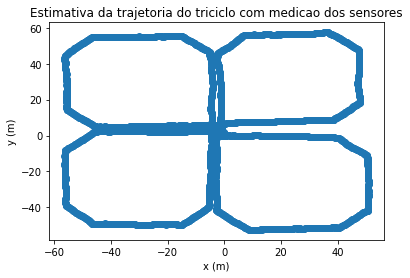

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(statesx, statesy)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Estimativa da trajetoria do triciclo com medicao dos sensores")
plt.show()
